In [1]:
import requests
from bs4 import BeautifulSoup
# pip install lxml
import pickle
import random
import igraph as ig
from collections import defaultdict

## Graph des directeurs de thèses --> thésards

Avec les données du site theses.fr, et l'api:
http://documentation.abes.fr/aidethesesfr/accueil/index.html#RecupererDonneesPagePersonne

Les info sur les thèses sont récupérées avec des requètes sur une personne, puis sur les personnes connexes. 


In [2]:
def parse_foaf(tag):
    try:
        name = tag.text
        person_id = tag.findChild().attrs['rdf:about']
    except KeyError:
        # print(tag)
        name, person_id = (tag.text, None)
    return (name, person_id)


def query_someone(person_id):
    url = person_id.replace('/id', '.xml')

    r = requests.get(url)
    
    soup = BeautifulSoup(r.text, 'lxml-xml')
    
    # own thesis
    agent = soup.find('foaf:Agent')
    person_id = agent.attrs['rdf:about']
    name = agent.find('name').text
    person = (name, person_id)
    
    # other thesis
    linked_thesis = []
    for th in soup.find_all('Thesis'):
        info = dict()
        info['title'] = th.find('title').text
        info['author'] = parse_foaf( th.find('aut') )
        info['id'] = th.attrs['rdf:about']
        info['url'] = th.find('identifier').text if th.find('identifier') else ''
        try:
            info['year'] = int(th.find('date').text)
        except ValueError:
            info['year'] = 0
        info['directors'] = [parse_foaf(ths) for ths in th.find_all('ths')]
        info['doctoral_school'] = parse_foaf(th.find('contributor')) if th.find('contributor') else ()
        info['univ'] = parse_foaf(th.find('dgg'))

        linked_thesis.append(info)

    return person, linked_thesis

In [3]:
def is_valid_id(foaf_id):
    return foaf_id.endswith('/id') and not foaf_id.endswith('//id')

In [25]:
# Objet qui stocke les données explorées
# et les requetes suivante à faire
class Blob():
    def __init__(self, seed_id):
        self.already_asked = set()
        self.to_search = set([seed_id, ])
        self.thesis = dict()
        self.seed = seed_id
        self.chains = dict()
        self.nbr_gen = 0
        self.name = seed_id.split('/')[-2]
        
    def grow(self):
        person_id = self.to_search.pop()
       
        full_id, results = query_someone(person_id)
        print(full_id[0], '(%i theses)'%len(results))
        self.already_asked.add(person_id)
        self.nbr_gen += 1
        
        a_dirige = []
        related = []
        own_thesis = {'author':full_id,
                      'year':0,
                      'id':None,
                      'directors':[]} # default value
        for th in results:
            if full_id == th['author']:
                own_thesis = th
            elif full_id in (d for d in th['directors']):
                a_dirige.append(th)
            else:
                related.append(th)

        a_dirige.sort(key=lambda x:x['year'])

        #print(len(results), len(a_dirige), len(related))
        co_directors = {d for th in a_dirige+[own_thesis, ]
                          for d in th['directors'] if d!=full_id}
        students = {th['author'] for th in a_dirige}

        new_person = [p[1] for p in co_directors | students
                      if is_valid_id(p[1]) and p[1] not in self.already_asked]

        self.to_search.update(new_person)
        self.thesis.update({th['id']:th for th in a_dirige})
        if len(a_dirige)>0:
            chain = [(th['author'], th['year']) for th in a_dirige]
            self.chains[full_id] = [(full_id, own_thesis['year']), ] + chain
            
        
    def save(self, name='blob.p'):
        pickle.dump(self, open( name, "wb" ))
        print("saved")
        
    def print_info(self):
        print('nbr thesis:', len(blob.thesis))
        print('nbr to search:', len(blob.to_search))
        print(self.seed, '+', self.nbr_gen, 'generations')

In [26]:
# Get a random seed
seedlist_file = "data/seedlist.pick"
try:
    seedlist = pickle.load( open( seedlist_file, "rb" ) )
    print('seedlist loaded:', len(seedlist), "seeds")
except FileNotFoundError:
    seedlist = ['http://www.theses.fr/197626394/id', ]
    pickle.dump(seedlist, open( seedlist_file, "wb" ))
    
seed_id = random.choice(seedlist)
print(seed_id)

# New graph
blob = Blob(seed_id)

seedlist loaded: 51 seeds
http://www.theses.fr/073011649/id


In [27]:
blob.grow()

Yannick Rondelez (5 theses)


In [29]:
# Grow
for _ in range(10):
    blob.grow()

print('')
blob.print_info()

Gaël De Leener (1 theses)
Ivan Jabin (6 theses)
Andrea Brugnara (1 theses)
Michel Maumy (2 theses)
Olivier Seneque (8 theses)
Benoît Colasson (8 theses)
Claudine Garapon (2 theses)
Luigi R. Nassimbeni (1 theses)
Éric Da Silva (1 theses)
Yannick Tauran (1 theses)

nbr thesis: 30
nbr to search: 14
http://www.theses.fr/073011649/id + 21 generations


In [30]:
# Chains
chs = sorted(blob.chains.values(), key=len, reverse=True)
len(chs)

10

In [ ]:
# Save
blobname = 'data/grosblob6.p'
blob.save(blobname)

## Subway map

In [31]:
# Build graph
links = []
for chain in blob.chains.values():
    source = chain[0][0]
    for target, year in chain[1:]:
        links.append((source, target))
        source = target
        
print(len(links))

37


In [32]:
links = list(set(links))
nodes = list(set(u[0] for ch in blob.chains.values() for u in ch))

In [33]:
print(len(links), len(nodes))

37 37


In [34]:
# Build graph
# graph
g = ig.Graph(directed=True)
g.add_vertices(nodes)
for chain in blob.chains.values():
    chain_id = chain[0][0]
    source = chain[0][0]
    for target, year in chain[1:]:
        link = (nodes.index(source), nodes.index(target))
        g.add_edge(*link, color=nodes.index(chain_id)%4)
        source = target
        
print(len(links))

37


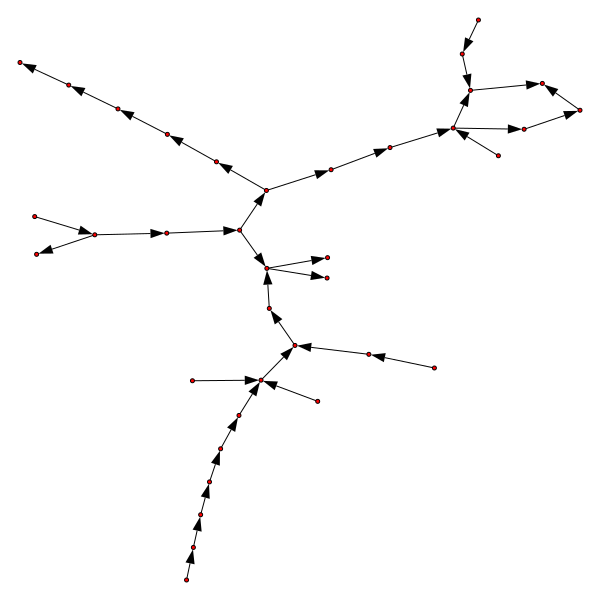

In [38]:
layout = g.layout_kamada_kawai()
ig.plot(g, vertex_size=4, layout=layout)
# https://igraph.org/python/doc/tutorial/tutorial.html

In [ ]:
# Export
g.write('subway.gml')

## Simple Graph

In [ ]:
# load
blob = pickle.load( open(blobname, "rb") )

In [41]:
thesis = list(blob.thesis.values())
print(len(thesis))

edges = set()
nodes = set()
for th in thesis:
    nodes.add(th['author'])
    for adviser in th['directors']:
        edges.add((th['author'], adviser))
        nodes.add(adviser)
        #break # only one adviser...
        
edges = list(edges)
nodes = list(nodes)
print('edges:', len(edges))
print('nodes:', len(nodes))

30
edges: 40
nodes: 39


In [42]:
edges_by_idx = [(nodes.index(u), nodes.index(v))
                for u, v in edges]

# graph
g = ig.Graph(directed=False)
g.add_vertices(nodes)
g.add_edges(edges_by_idx)

print('vertex:', len(g.vs))

vertex: 39


https://schneide.blog/tag/fruchterman-reingold/

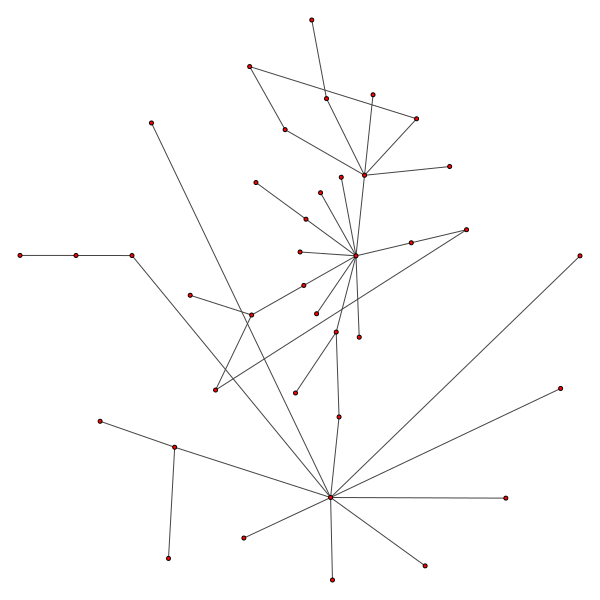

In [45]:
layout = g.layout_reingold_tilford_circular()
#layout = g.layout_kamada_kawai()
ig.plot(g, vertex_size=4, layout=layout)
# https://igraph.org/python/doc/tutorial/tutorial.html